In [193]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import pandas as pd

In [361]:
def analyze_retail_sales(sales_data: pd.Series, d=1, forecast_days: int = 30):
    """
    Analyzes retail sales data using Fourier Transform to identify seasonal components,
    visualize the frequency spectrum, and generate a forecast.

    Args:
        sales_data (pd.Series): Time series data of retail sales.  Index should be datetime.
        forecast_days (int): Number of days to forecast.

    Returns:
        None: Displays the frequency spectrum plot and the forecast plot.
    """
    # 1. Data Preparation: Ensure the input is a pandas Series.
    if not isinstance(sales_data, pd.Series):
        raise ValueError("Input data must be a pandas Series.")
    if sales_data.isnull().any():
        raise ValueError("Input data cannot contain NaN values.")

    # 2. Apply FFT
    n = len(sales_data)
    yf = fft(sales_data.values)
    xf = np.fft.fftfreq(n, d=1) # Assuming daily data, d=1.  Adjust if different frequency.

    # Only keep the positive half of frequencies
    positive_mask = xf > 0
    yf2 = np.abs(yf[positive_mask])
    xf2 = xf[positive_mask]

    # Get index of the top 3 frequencies
    top_idx = np.argsort(yf2.flatten())[-3:][::-1]
    top_freqs = xf2[top_idx]
    top_cycles = (1 / top_freqs).astype(int)

    print("Dominant cycle lengths (in days):", top_cycles)

    # 3. Visualize Frequency Spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(xf2, yf2) # Plot only the positive frequencies
    plt.title("Frequency Spectrum of Retail Sales")
    plt.xlabel("Frequency (days)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    print("\n\n")

    # Highlight Major Seasonal Components - Identify the top 3 frequencies
    for idx in top_idx:
        frequency = xf2[idx]
        plt.axvline(x=frequency, color='red', linestyle='--', alpha=0.7, label=f"Seasonal Component {1/frequency:.0f}")
    plt.legend()
    plt.show()
    print("\n\n")


    # 4. Forecasting
    # Create a copy of the frequency data for modification
    yf_forecast = yf.copy()
    # Zero out the high-frequency components (optional, for smoothing)
    # yf_forecast[np.abs(xf) > 0.1] = 0 # Example: Zero out frequencies above 0.1.  Adjust the threshold

    # Inverse FFT for initial reconstruction
    sales_reconstructed = ifft(yf_forecast).real # Take the real part to avoid complex numbers from numerical errors.

    # Extrapolate the data
    future_x = np.arange(n + forecast_days)
    yf_extended = np.zeros(len(future_x), dtype=np.complex128)
    yf_extended[:n] = yf_forecast # Extend with the existing data

    # IFFT on the extended data
    sales_forecast = ifft(yf_extended).real

    # 5. Plotting the Forecast
    plt.figure(figsize=(12, 6))
    plt.plot(sales_data.index, sales_data, label='Original Data', alpha=0.7)
    # Use the index of the original data to plot the forecast
    forecast_index = pd.date_range(start=sales_data.index[-1], periods=forecast_days + 1, inclusive='right')
    plt.plot(forecast_index, sales_forecast[n:], label=f'Forecast ({forecast_days} days)', linestyle='--')
    plt.title("Retail Sales Forecast using Fourier Transform")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("\n\n")

Dominant cycle lengths (in days): [ 30  28 182]





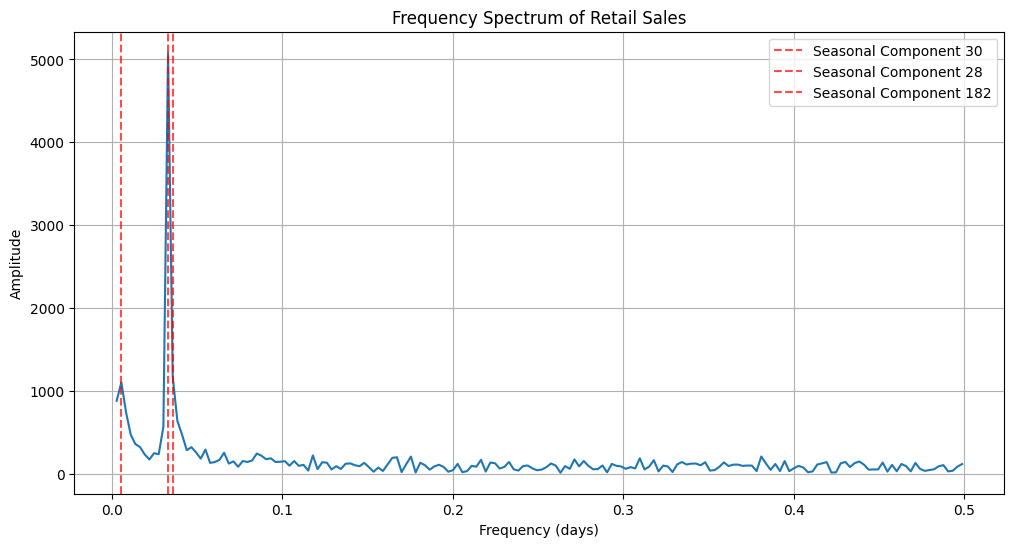

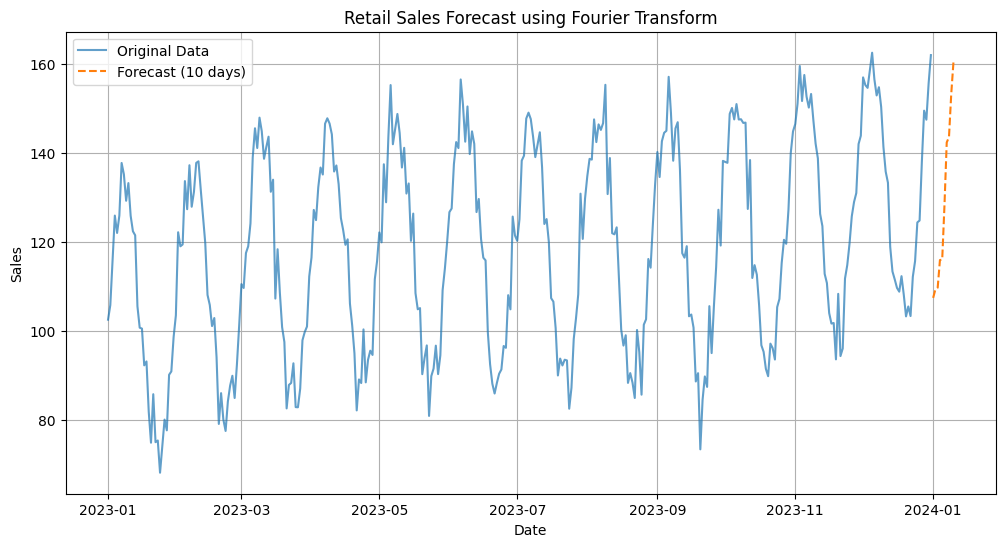

In [362]:
# Example Usage (Simulated Data)
np.random.seed(42) # for reproducibility
time_index = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Simulate daily sales with seasonality
# Base Trend
base_sales = 100 + np.arange(len(time_index)) * 0.1

# Yearly Seasonality (365 days)
yearly_seasonality = 7 * np.sin(2 * np.pi * np.arange(len(time_index)) / 365)

# Monthly seasonality
monthly_seasonality = 30 * np.sin(2 * np.pi * np.arange(len(time_index)) / 30) # Approx. 30 days

# Adding Random noise
noise = np.random.normal(0, 5, len(time_index))

# Creating the simulated data
sales_data_simulated = pd.Series(base_sales + yearly_seasonality + monthly_seasonality + noise, index=time_index)

# Running the function
analyze_retail_sales(sales_data_simulated, forecast_days=10)


In [21]:
!pip install ucimlrepo --quiet

In [332]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

df = pd.concat([X, y], axis=1)

In [333]:
# Preparing the data
# Date variable to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add total expense by invoice
df['total'] = df['Quantity'] * df['UnitPrice']

# Set date as index
df.set_index('InvoiceDate', inplace=True)

In [334]:
# Resample data by day
df_by_day = df.resample('D').sum()['total']

In [335]:
df_by_day.head(3)

,total
InvoiceDate,
2010-12-01,58635.56
2010-12-02,46207.28
2010-12-03,45620.46


Dominant cycle lengths (in days): [  7 374   3]





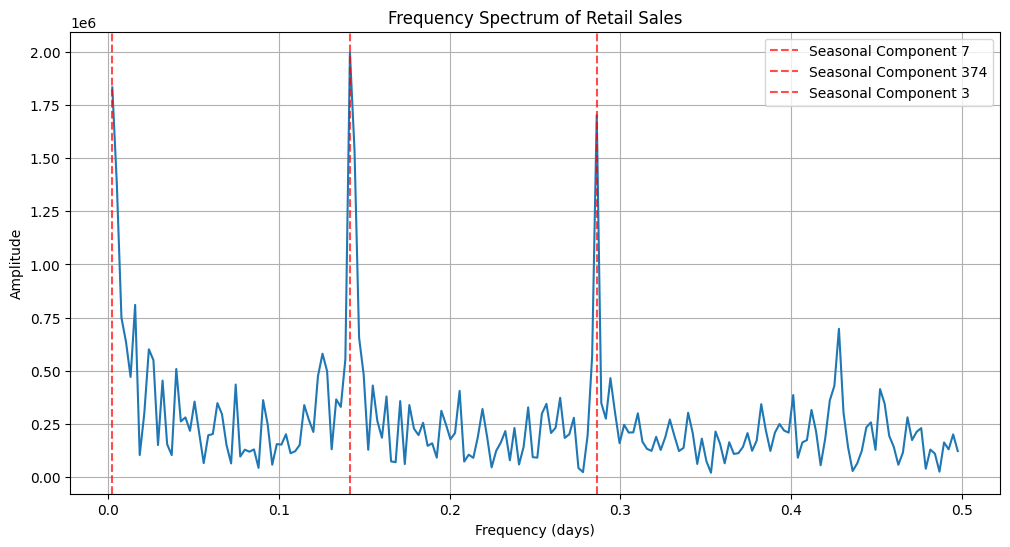

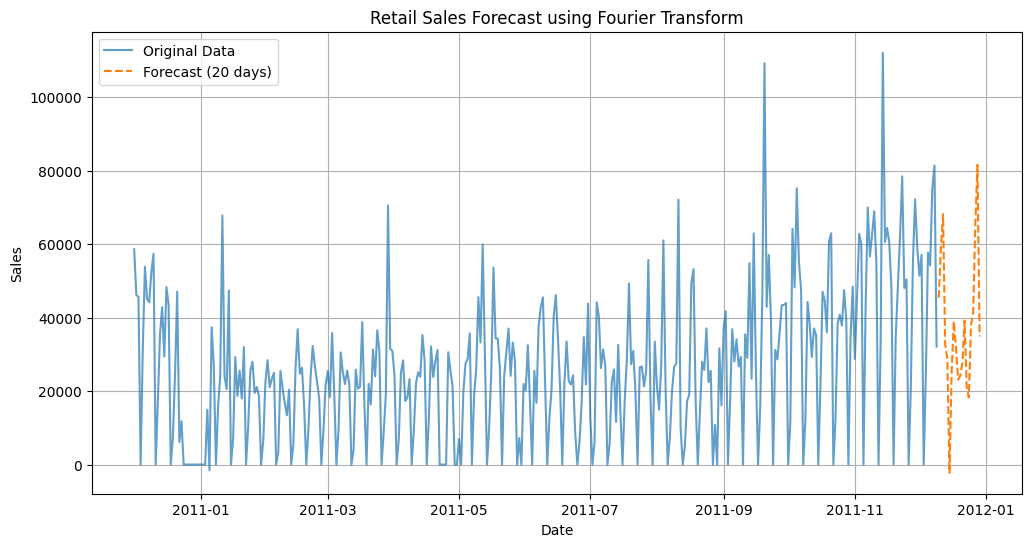

In [363]:
# Running FT the function
analyze_retail_sales(df_by_day, forecast_days=20)

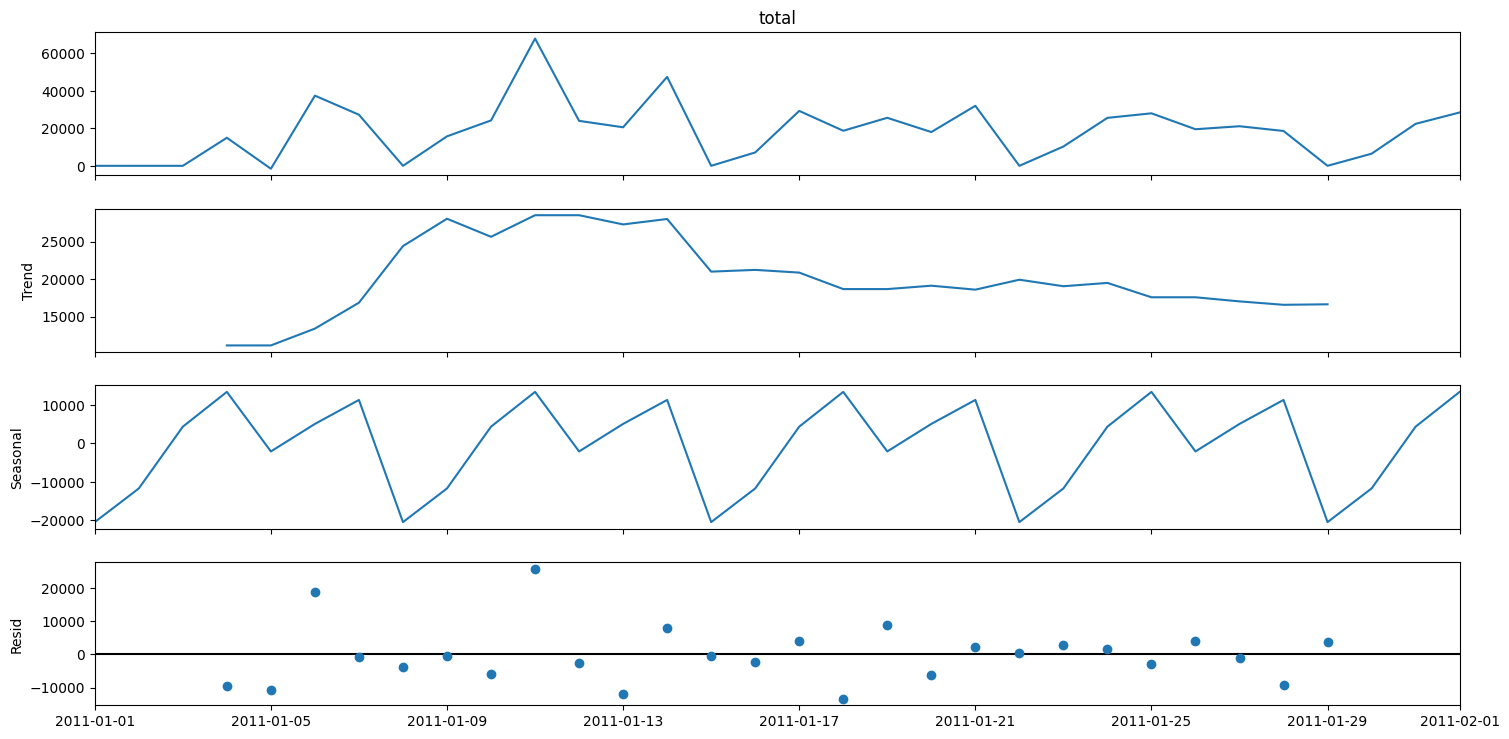

In [322]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df_by_day["2011-01-01":"2011-02-01"], model='additive').plot().set_size_inches((18, 8)) # Set width to 18 inches, height to 8 inches
plt.show()